## 批量更新 TD 与 MC
### Example 6.3 with Figure 6.2
### 随机游走

In [3]:
import numpy as np
import random
from gridworld import RandomWalk
from tqdm import tqdm


import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline        

In [30]:
'''
    以下内容与Example 6.2一样
'''
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE[6] = 1  

VALUES = np.ones(7)*0.5 #初始化近似价值函数 0，0.5...0.5,1
VALUES[0] = 0
VALUES[6] = 1

def temporal_difference(env, V, alpha=0.1, discount_factor=1.0, batch=False): #alpha步长
    s = env.reset() #从中间开始
    trajectory = [s]
    rewards = [0]
    while True:
        a = env.action_space.sample() #policy： 向左 向右 均匀概率采样
        s_, r, done, info =  env.step(a)
        r = 0  #不明白为什么 只有假设所有的reward=0 才能复现书上的结果。。。
        trajectory.append(s_)
        if not batch:
            #TD update
            V[s] += alpha * (r + discount_factor * V[s_] - V[s] )
            
        if done:
            break
        rewards.append(r)
        s = s_  
    return trajectory, rewards     
        
        
def monte_carlo(env, V, alpha=0.1, batch=False):
    s = env.reset()
    trajectory = [s]
    while True:
        a = env.action_space.sample() 
        s_, r, done, info = env.step(a)
        trajectory.append(s_)
        if done:
            G = r #每个epsido结束之后的最终rewar作为累积回报G
            break
            
    if not batch:
        for s in trajectory[:-1]: #终止态不进入计算
            #MC update
            V[s] += alpha * (G - V[s])
    return trajectory, [G] * (len(trajectory)-1)
    

In [6]:
env = RandomWalk()
s = env.reset()
trajectory = [s]
while True:
    a = env.action_space.sample() 
    s_, r, done, info = env.step(a)
    trajectory.append(s_)
    if done:
        returns = r #每个epsido结束之后的最终rewar作为累积回报G
        break

In [31]:
def batch_updating(method, episodes, alpha=0.001, discount_factor=1.0):
    # perform 100 independent runs
    runs = 100
    env = RandomWalk()

    total_errors = np.zeros(episodes)
    for r in tqdm(range(0, runs)):
        current_values = np.copy(VALUES)
        errors = []
        # track shown trajectories and reward/return sequences
        trajectories = []
        rewards = []
        for ep in range(episodes):
            if method == 'TD':
                trajectory_, rewards_ = temporal_difference(env, current_values, batch=True)
            else:
                trajectory_, rewards_ = monte_carlo(env, current_values, batch=True)
            trajectories.append(trajectory_)
            rewards.append(rewards_)
            while True:
                # keep feeding our algorithm with trajectories seen so far until state value function converges
                updates = np.zeros(7)
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    for i in range(0, len(trajectory_) - 1):
                        if method == 'TD': #Batch TD update
                            updates[trajectory_[i]] += rewards_[i] + discount_factor*current_values[trajectory_[i + 1]] - current_values[trajectory_[i]]
                        else: #Batch MC update
                            updates[trajectory_[i]] += rewards_[i] - current_values[trajectory_[i]]
                updates *= alpha
                if np.sum(np.abs(updates)) < 1e-3:
                    break
                # perform batch updating
                current_values += updates
            # calculate rms error
            errors.append(np.sqrt(np.sum(np.power(current_values - TRUE_VALUE, 2)) / 5.0))
        total_errors += np.asarray(errors)
    total_errors /= runs
    return total_errors

100%|██████████| 100/100 [00:37<00:00,  2.63it/s]
/Users/lmc/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


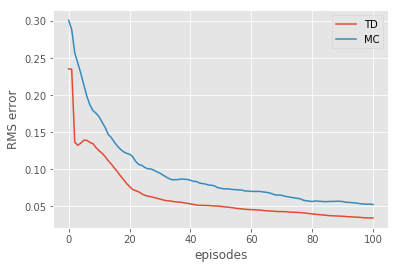

In [32]:
episodes = 100 + 1
td_erros = batch_updating('TD', episodes)
mc_erros = batch_updating('MC', episodes)

plt.plot(td_erros, label='TD')
plt.plot(mc_erros, label='MC')
plt.xlabel('episodes')
plt.ylabel('RMS error')
plt.legend()

plt.show()
#plt.savefig('../images/figure_6_2.png')
#plt.close()

In [40]:

plt.plot(td_erros, label='TD')
plt.plot(mc_erros, label='MC')
plt.xlabel('episodes')
plt.ylabel('RMS error')
plt.legend()

#plt.show()
plt.savefig('./images/figure_6_2.png')
plt.close()